In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
from collections import Counter
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report,
                           precision_recall_curve, average_precision_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout,
                                   LayerNormalization, MultiHeadAttention,
                                   GlobalAveragePooling1D, Add, Concatenate,
                                   Layer, Lambda, Multiply, Reshape,
                                   BatchNormalization, Activation)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv('train_test_network.csv')
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.3715,101568,2592,OTH,0,108,108064,31,3832,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.0001,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.0001,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.0001,0,0,REJ,0,1,48,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.0001,0,0,REJ,0,1,52,1,40,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

,src_port,dst_port,duration,src_bytes,dst_bytes,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_qclass,dns_qtype,dns_rcode,http_request_body_len,http_response_body_len,http_status_code,label
count,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000,211043.0000
mean,38646.5195,3495.1538,7.7009,258113.5643,258804.5716,34432.3443,9.5952,776.0822,3.8469,1584.6866,227.6308,3.6109,0.1240,0.0654,144.9295,0.3039,0.7631
std,19307.2710,10191.6248,564.1419,17094901.2498,18025629.2483,5261620.8969,91.7788,22297.0275,330.7058,190179.5241,2720.7136,23.7977,0.5988,9.2434,30472.4392,8.2704,0.4252
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,34608.0000,65.0000,0.0000,0.0000,0.0000,0.0000,1.0000,48.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50%,44754.0000,80.0000,0.0002,0.0000,0.0000,0.0000,1.0000,82.0000,1.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,51133.0000,1253.0000,0.0542,130.0000,89.0000,0.0000,4.0000,415.0000,2.0000,134.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
max,65528.0000,65467.0000,93516.9292,3890855126.0000,3913853482.0000,1854527046.0000,24623.0000,6522626.0000,121942.0000,86395523.0000,32769.0000,255.0000,5.0000,2338.0000,13424384.0000,404.0000,1.0000


In [5]:
print("\nLabel Distribution:")
print(df['label'].value_counts())
print("\nAttack Type Distribution:")
print(df['type'].value_counts())


Label Distribution:
label
1    161043
0     50000
Name: count, dtype: int64

Attack Type Distribution:
type
normal        50000
backdoor      20000
ddos          20000
dos           20000
injection     20000
password      20000
scanning      20000
ransomware    20000
xss           20000
mitm           1043
Name: count, dtype: int64


In [6]:
print("\nNumeric Features Statistics:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe())


Numeric Features Statistics:
         src_port    dst_port    duration       src_bytes       dst_bytes  \
count 211043.0000 211043.0000 211043.0000     211043.0000     211043.0000   
mean   38646.5195   3495.1538      7.7009     258113.5643     258804.5716   
std    19307.2710  10191.6248    564.1419   17094901.2498   18025629.2483   
min        1.0000      0.0000      0.0000          0.0000          0.0000   
25%    34608.0000     65.0000      0.0000          0.0000          0.0000   
50%    44754.0000     80.0000      0.0002          0.0000          0.0000   
75%    51133.0000   1253.0000      0.0542        130.0000         89.0000   
max    65528.0000  65467.0000  93516.9292 3890855126.0000 3913853482.0000   

         missed_bytes    src_pkts  src_ip_bytes    dst_pkts  dst_ip_bytes  \
count     211043.0000 211043.0000   211043.0000 211043.0000   211043.0000   
mean       34432.3443      9.5952      776.0822      3.8469     1584.6866   
std      5261620.8969     91.7788    22297.02

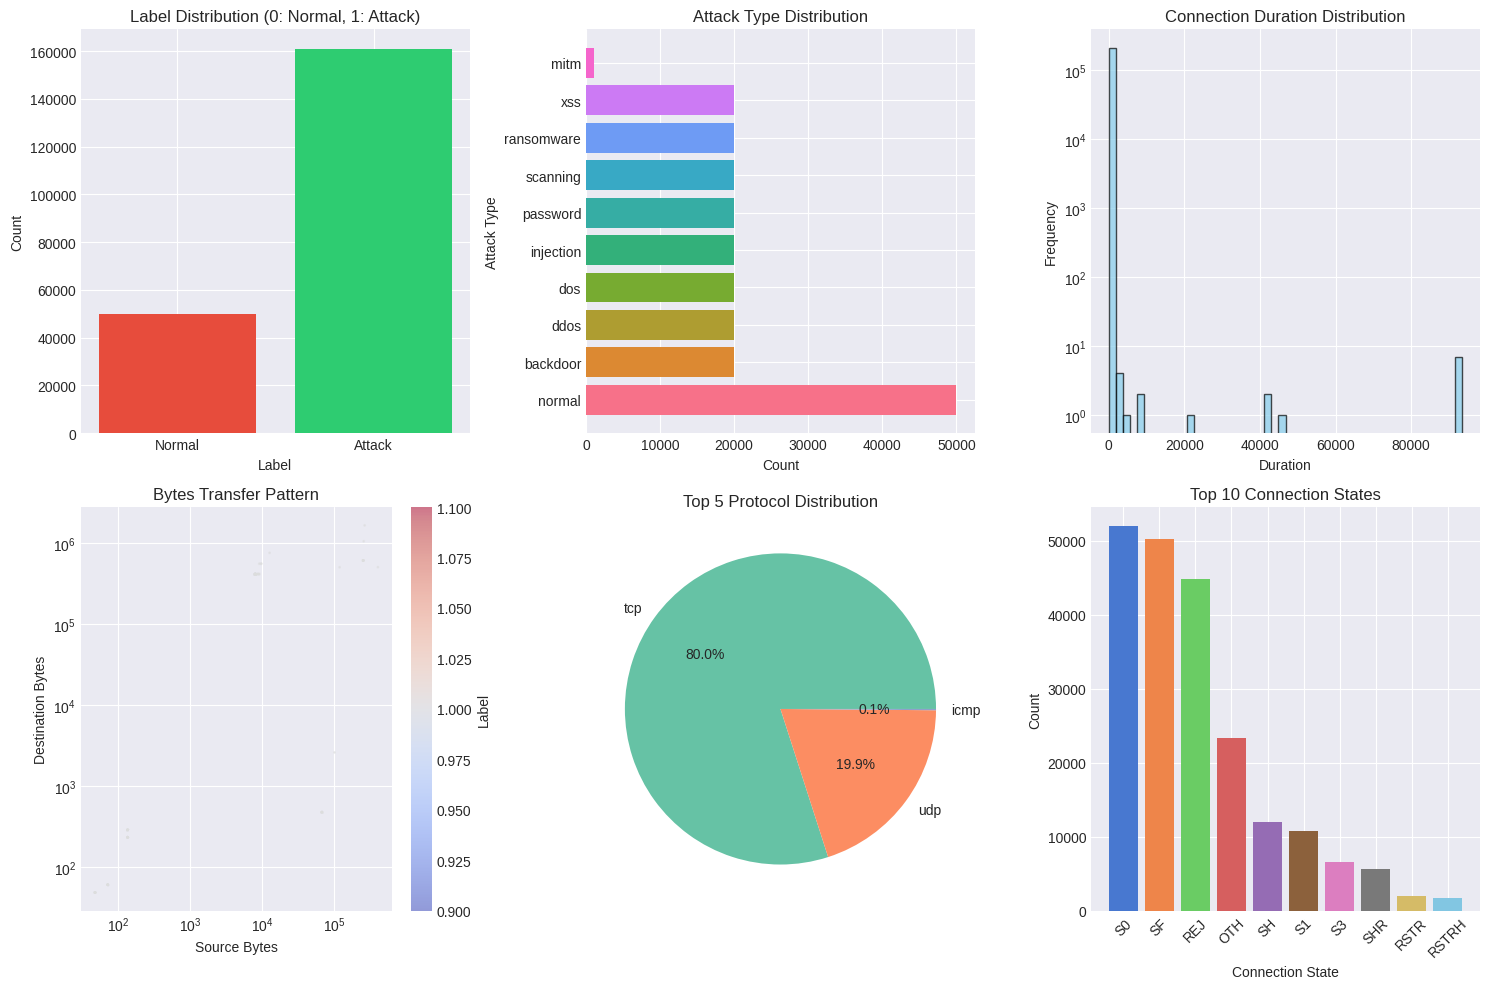

In [7]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color=['#2ecc71', '#e74c3c'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution (0: Normal, 1: Attack)')
plt.xticks([0, 1], ['Normal', 'Attack'])

plt.subplot(2, 3, 2)
type_counts = df['type'].value_counts()
plt.barh(range(len(type_counts)), type_counts.values, color=sns.color_palette("husl", len(type_counts)))
plt.yticks(range(len(type_counts)), type_counts.index)
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.title('Attack Type Distribution')

plt.subplot(2, 3, 3)
plt.hist(df['duration'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Connection Duration Distribution')
plt.yscale('log')

plt.subplot(2, 3, 4)
plt.scatter(df['src_bytes'][:10000], df['dst_bytes'][:10000],
           c=df['label'][:10000], cmap='coolwarm', alpha=0.5, s=1)
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.title('Bytes Transfer Pattern')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Label')

plt.subplot(2, 3, 5)
proto_counts = df['proto'].value_counts().head(5)
plt.pie(proto_counts.values, labels=proto_counts.index, autopct='%1.1f%%',
       colors=sns.color_palette("Set2"))
plt.title('Top 5 Protocol Distribution')

plt.subplot(2, 3, 6)
conn_state_counts = df['conn_state'].value_counts().head(10)
plt.bar(range(len(conn_state_counts)), conn_state_counts.values,
       color=sns.color_palette("muted", len(conn_state_counts)))
plt.xticks(range(len(conn_state_counts)), conn_state_counts.index, rotation=45)
plt.xlabel('Connection State')
plt.ylabel('Count')
plt.title('Top 10 Connection States')

plt.tight_layout()
plt.show()

In [8]:
def extract_ip_features(ip_str):
    try:
        parts = ip_str.split('.')
        return [int(p) for p in parts]
    except:
        return [0, 0, 0, 0]

def create_traffic_features(df):
    df_features = df.copy()

    df_features['byte_ratio'] = np.where(df_features['dst_bytes'] > 0,
                                         df_features['src_bytes'] / (df_features['dst_bytes'] + 1),
                                         df_features['src_bytes'])

    df_features['pkt_ratio'] = np.where(df_features['dst_pkts'] > 0,
                                        df_features['src_pkts'] / (df_features['dst_pkts'] + 1),
                                        df_features['src_pkts'])

    df_features['avg_pkt_size_src'] = np.where(df_features['src_pkts'] > 0,
                                               df_features['src_bytes'] / df_features['src_pkts'],
                                               0)

    df_features['avg_pkt_size_dst'] = np.where(df_features['dst_pkts'] > 0,
                                               df_features['dst_bytes'] / df_features['dst_pkts'],
                                               0)

    df_features['total_bytes'] = df_features['src_bytes'] + df_features['dst_bytes']
    df_features['total_pkts'] = df_features['src_pkts'] + df_features['dst_pkts']

    df_features['byte_rate'] = np.where(df_features['duration'] > 0,
                                        df_features['total_bytes'] / df_features['duration'],
                                        df_features['total_bytes'])

    df_features['pkt_rate'] = np.where(df_features['duration'] > 0,
                                       df_features['total_pkts'] / df_features['duration'],
                                       df_features['total_pkts'])

    df_features['is_dns'] = (df_features['service'] == 'dns').astype(int)
    df_features['is_http'] = (df_features['service'] == 'http').astype(int)
    df_features['is_ssl'] = (df_features['service'] == 'ssl').astype(int)

    df_features['has_dns_query'] = (df_features['dns_query'] != '-').astype(int)
    df_features['has_http_method'] = (df_features['http_method'] != '-').astype(int)
    df_features['has_ssl'] = (df_features['ssl_version'] != '-').astype(int)

    return df_features

In [9]:
def encode_categorical_features(df):
    df_encoded = df.copy()

    categorical_cols = ['proto', 'service', 'conn_state']

    for col in categorical_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col].astype(str))
            joblib.dump(le, f'{col}_encoder.pkl')

    return df_encoded

In [10]:
df_processed = create_traffic_features(df)
df_processed = encode_categorical_features(df_processed)

numeric_features = [
    'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes',
    'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes',
    'dns_qclass', 'dns_qtype', 'dns_rcode',
    'http_request_body_len', 'http_response_body_len', 'http_status_code',
    'byte_ratio', 'pkt_ratio', 'avg_pkt_size_src', 'avg_pkt_size_dst',
    'total_bytes', 'total_pkts', 'byte_rate', 'pkt_rate',
    'is_dns', 'is_http', 'is_ssl', 'has_dns_query', 'has_http_method', 'has_ssl',
    'proto_encoded', 'service_encoded', 'conn_state_encoded'
]

X = df_processed[numeric_features].values.astype(np.float32)
y = df_processed['label'].values.astype(np.float32)

print(f"\nOriginal Feature matrix shape: {X.shape}")
print(f"Original Label shape: {y.shape}")
print(f"\nOriginal Label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {int(label)}: {count} ({count/len(y)*100:.2f}%)")


Original Feature matrix shape: (211043, 33)
Original Label shape: (211043,)

Original Label distribution:
Label 0: 50000 (23.69%)
Label 1: 161043 (76.31%)


In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape}")
print(f"  Class 0: {(y_train==0).sum():,}, Class 1: {(y_train==1).sum():,}")
print(f"Validation set: {X_val.shape}")
print(f"  Class 0: {(y_val==0).sum():,}, Class 1: {(y_val==1).sum():,}")
print(f"Test set: {X_test.shape}")
print(f"  Class 0: {(y_test==0).sum():,}, Class 1: {(y_test==1).sum():,}")

Train set: (168834, 33)
  Class 0: 40,000, Class 1: 128,834
Validation set: (21104, 33)
  Class 0: 5,000, Class 1: 16,104
Test set: (21105, 33)
  Class 0: 5,000, Class 1: 16,105


In [12]:
print(f"\nBefore SMOTE - Train set: {X_train.shape}")
print(f"  Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE - Train set: {X_train_balanced.shape}")
print(f"  Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")


Before SMOTE - Train set: (168834, 33)
  Class 0: 40000, Class 1: 128834

After SMOTE - Train set: (257668, 33)
  Class 0: 128834, Class 1: 128834


In [13]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=1e6, neginf=-1e6)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

joblib.dump(scaler, 'robust_scaler.pkl')

print(f"Final train samples: {len(X_train_scaled):,}")
print(f"Scaled train data range: [{X_train_scaled.min():.4f}, {X_train_scaled.max():.4f}]")

Final train samples: 168,834
Scaled train data range: [-2.7105, 6766226432.0000]


In [14]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred >= 0.5, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros', dtype=tf.float32)
        self.tn = self.add_weight(name='tn', initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred >= 0.5, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        sensitivity = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        balanced_acc = (sensitivity + specificity) / 2.0
        return balanced_acc

    def reset_state(self):
        self.tp.assign(0.0)
        self.tn.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

In [15]:
class AdaptiveAttentionLayer(Layer):
    def __init__(self, attention_dim=64, **kwargs):
        super(AdaptiveAttentionLayer, self).__init__(**kwargs)
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W_attention = self.add_weight(
            name='W_attention',
            shape=(input_shape[-1], self.attention_dim),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b_attention = self.add_weight(
            name='b_attention',
            shape=(self.attention_dim,),
            initializer='zeros',
            trainable=True
        )
        self.u_attention = self.add_weight(
            name='u_attention',
            shape=(self.attention_dim, 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.threat_weight = self.add_weight(
            name='threat_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AdaptiveAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        threat_score = tf.nn.sigmoid(tf.matmul(inputs, self.threat_weight))

        attention_hidden = tf.nn.tanh(tf.matmul(inputs, self.W_attention) + self.b_attention)
        attention_score = tf.matmul(attention_hidden, self.u_attention)
        attention_score = tf.nn.softmax(attention_score, axis=1)

        adaptive_attention = attention_score * (1.0 + threat_score)
        adaptive_attention = adaptive_attention / (tf.reduce_sum(adaptive_attention, axis=1, keepdims=True) + K.epsilon())

        context_vector = inputs * adaptive_attention

        return context_vector, adaptive_attention

    def get_config(self):
        config = super(AdaptiveAttentionLayer, self).get_config()
        config.update({'attention_dim': self.attention_dim})
        return config

In [16]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, sequence_length, d_model):
        angle_rads = self.get_angles(
            position=tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'd_model': self.d_model
        })
        return config

In [17]:
class AdaptiveTransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(AdaptiveTransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.adaptive_attention = AdaptiveAttentionLayer(attention_dim=embed_dim // 2)

    def call(self, inputs, training=False):
        adaptive_input, attention_weights = self.adaptive_attention(inputs)

        attn_output = self.att(adaptive_input, adaptive_input)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

    def get_config(self):
        config = super(AdaptiveTransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

In [18]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss_value = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)

        return tf.reduce_mean(focal_loss_value)

    return focal_loss_fixed

In [19]:
def focal_loss(gamma=2.0, alpha=0.76):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_loss_value = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)

        return tf.reduce_mean(focal_loss_value)

    focal_loss_fixed.__name__ = 'focal_loss_fixed'
    return focal_loss_fixed

get_custom_objects()['focal_loss_fixed'] = focal_loss(gamma=2.0, alpha=0.76)

In [20]:
SEQUENCE_LENGTH = 1
FEATURE_DIM = X_train_scaled.shape[1]
EMBED_DIM = 128
NUM_HEADS = 8
FF_DIM = 256
NUM_TRANSFORMER_BLOCKS = 3
DROPOUT_RATE = 0.4

def build_adaptive_transformer_model(input_dim, sequence_length=1, embed_dim=128,
                                    num_heads=8, ff_dim=256, num_blocks=3, dropout_rate=0.4):

    inputs = Input(shape=(input_dim,))
    x = Reshape((sequence_length, input_dim))(inputs)

    x = Dense(embed_dim)(x)
    x = PositionalEncoding(sequence_length, embed_dim)(x)
    x = Dropout(dropout_rate)(x)

    for _ in range(num_blocks):
        x = AdaptiveTransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = build_adaptive_transformer_model(
    input_dim=FEATURE_DIM,
    sequence_length=SEQUENCE_LENGTH,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 33)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 128)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 1, 128)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_transformer_block      │ (None, 1, 128)         │       602,368 │
│ (AdaptiveTransformerBlock)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_transformer_block_1    │ (None, 1, 128)         │       602,368 │
│ (AdaptiveTransformerBlock)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_transformer_block_2    │ (None, 1, 128)         │       602,368 │
│ (AdaptiveTransformerBlock)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,057 (7.01 MB)

 Trainable params: 1,836,673 (7.01 MB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

focal_loss_fn = focal_loss(gamma=2.0, alpha=0.76)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',   # lebih simpel & cocok karena train sudah seimbang
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(),
        BalancedAccuracy()
    ]
)

In [22]:
callbacks_list = [
    EarlyStopping(
        monitor='val_balanced_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_balanced_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'best_adaptive_transformer_model.keras',
        monitor='val_balanced_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [23]:
BATCH_SIZE = 256
EPOCHS = 100

history = model.fit(
    X_train_scaled, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9046 - auc: 0.9416 - balanced_accuracy: 0.5010 - f1_score: 0.7624 - loss: 0.9338 - precision: 0.9393 - recall: 0.9353
Epoch 1: val_balanced_accuracy improved from -inf to 0.50140, saving model to best_adaptive_transformer_model.keras
660/660 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9047 - auc: 0.9416 - balanced_accuracy: 0.5010 - f1_score: 0.7624 - loss: 0.9330 - precision: 0.9394 - recall: 0.9353 - val_accuracy: 0.9764 - val_auc: 0.9836 - val_balanced_accuracy: 0.5014 - val_f1_score: 0.7614 - val_loss: 0.1140 - val_precision: 0.9874 - val_recall: 0.9816 - learning_rate: 0.0010
Epoch 2/100
657/660 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9733 - auc: 0.9830 - balanced_accuracy: 0.5016 - f1_score: 0.7624 - loss: 0.1160 - precision: 0.9855 - recall: 0.9795
Epoch 2: val_balanced_accuracy improved from 0.50140 to 0.50143, saving model to best_adaptive_transformer_model.keras
660/660 ━━━━━━━━━━━━━━━━━━━━ 7s 10m

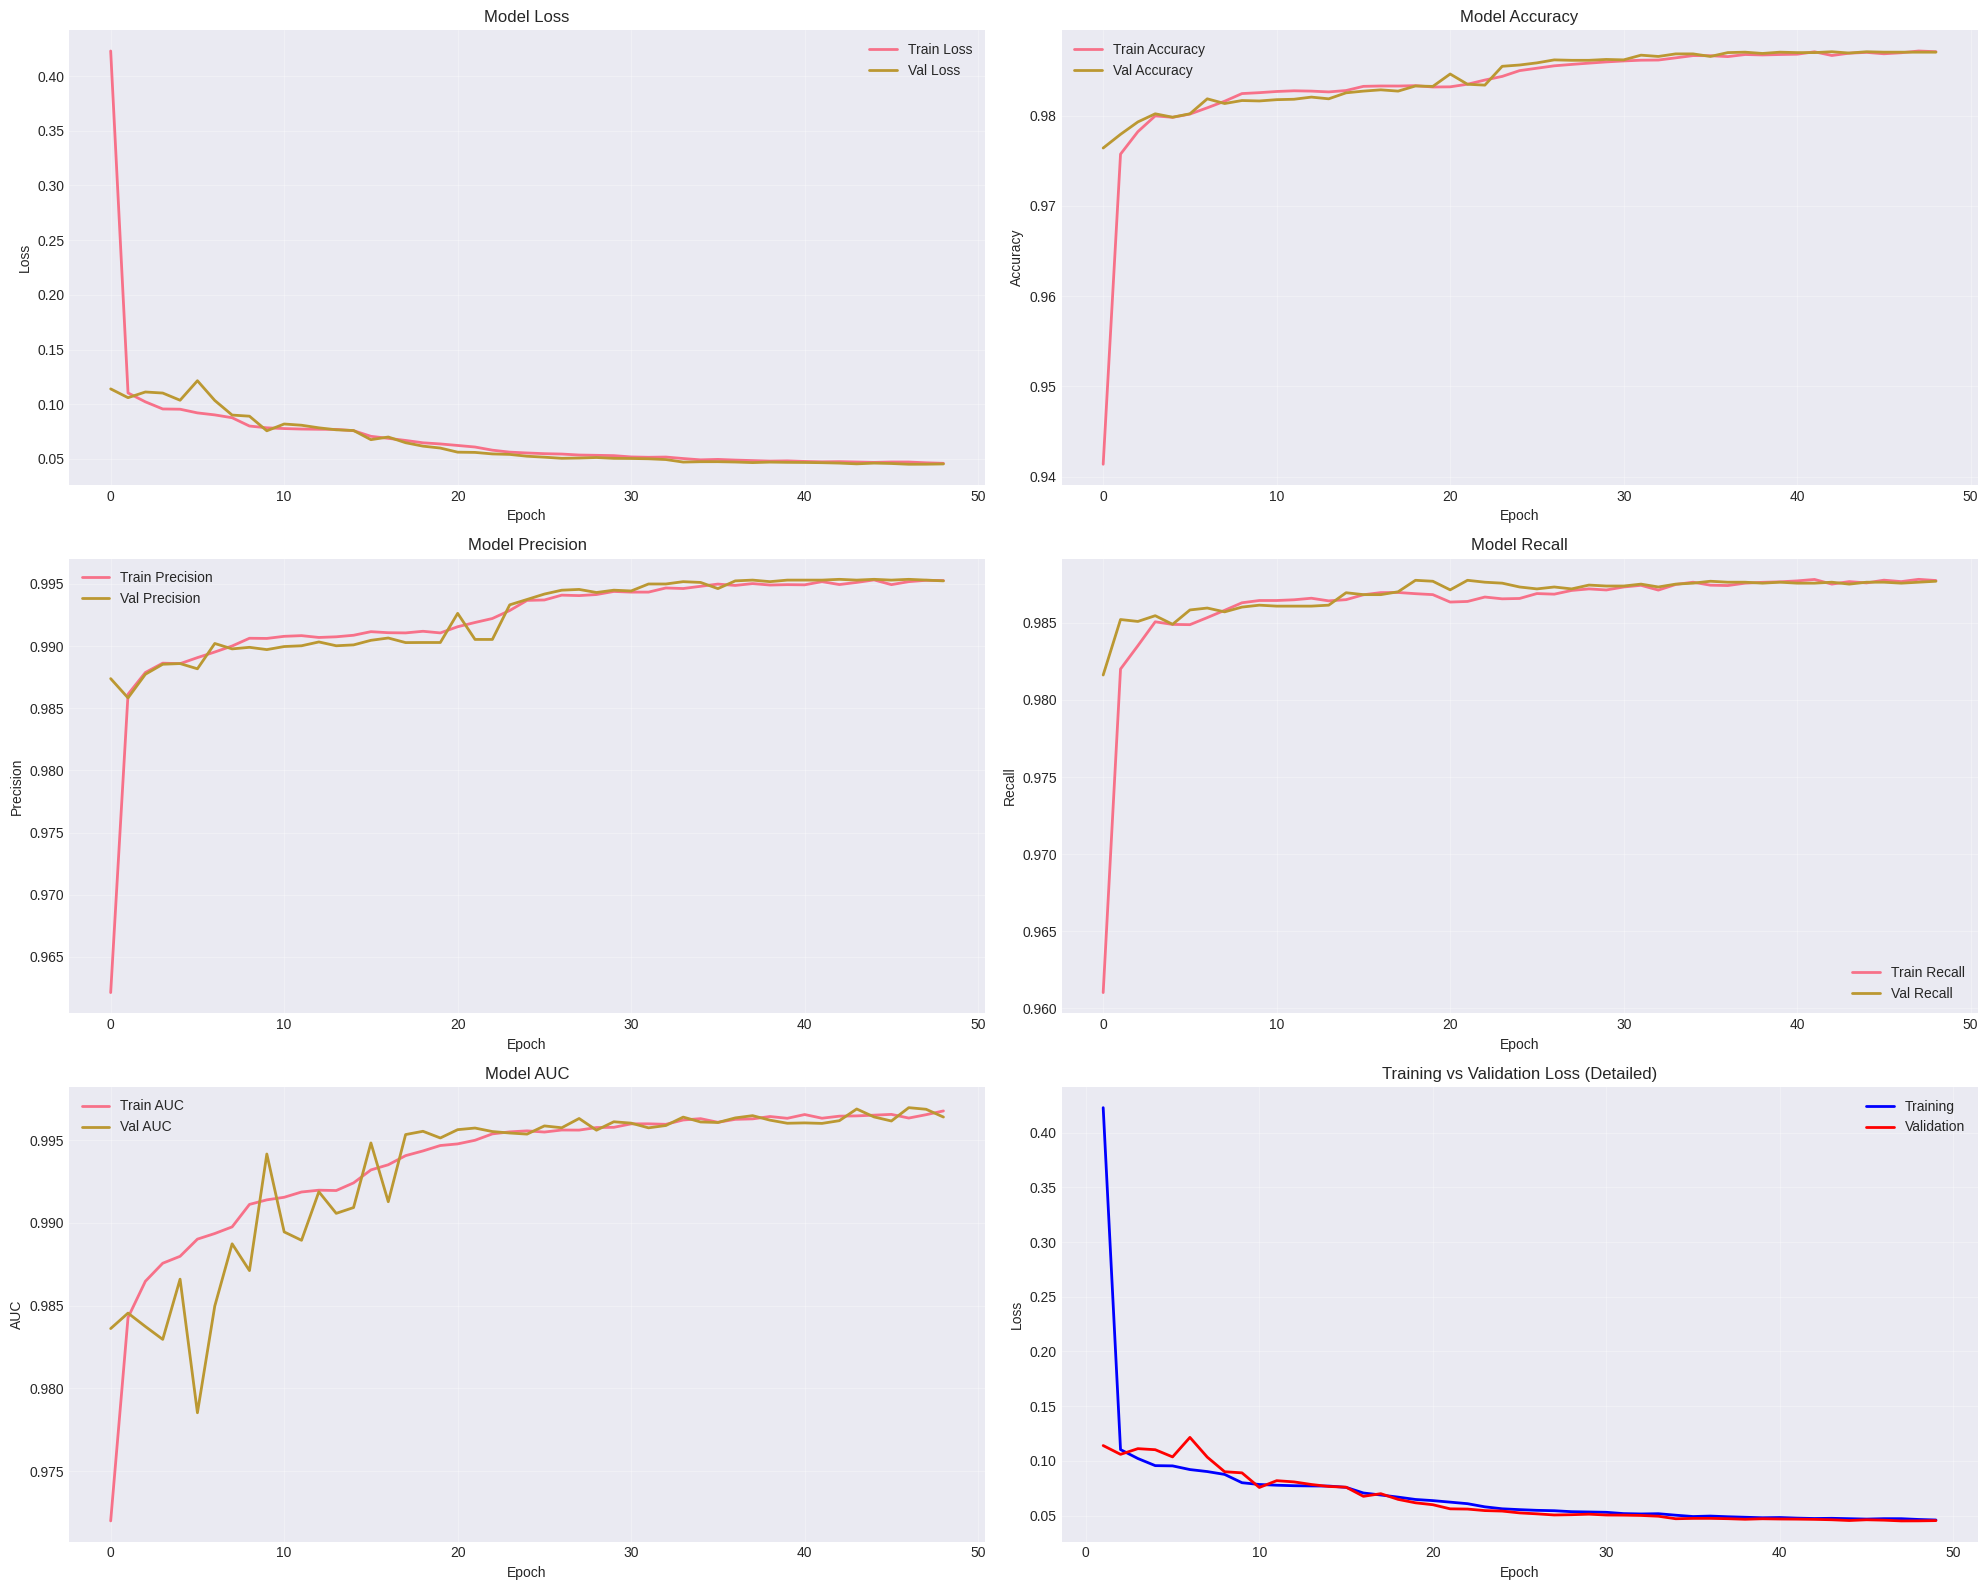

In [38]:
plt.figure(figsize=(20, 16))

plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Train Precision', linewidth=2)
plt.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Train Recall', linewidth=2)
plt.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.plot(history.history['auc'], label='Train AUC', linewidth=2)
plt.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
epochs_range = range(1, len(history.history['loss']) + 1)
plt.plot(epochs_range, history.history['loss'], 'b-', label='Training', linewidth=2)
plt.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
plt.title('Training vs Validation Loss (Detailed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    y_pred_prob = model.predict(X, batch_size=512, verbose=0).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, y_pred_prob)

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2.0

    avg_precision = average_precision_score(y, y_pred_prob)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'balanced_accuracy': balanced_acc,
        'avg_precision': avg_precision,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

    print(f"\n{dataset_name} Performance:")
    print(f"  Accuracy:          {accuracy:.4f}")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    print(f"  F1-Score:          {f1:.4f}")
    print(f"  ROC-AUC:           {roc_auc:.4f}")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}")
    print(f"  Average Precision: {avg_precision:.4f}")
    print(f"  Sensitivity:       {sensitivity:.4f}")
    print(f"  Specificity:       {specificity:.4f}")

    return metrics, y_pred, y_pred_prob, cm

def find_optimal_threshold(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [26]:
val_metrics, val_pred, val_pred_prob, val_cm = evaluate_model(
    model, X_val_scaled, y_val, "Validation Set"
)

test_metrics, test_pred, test_pred_prob, test_cm = evaluate_model(
    model, X_test_scaled, y_test, "Test Set"
)

optimal_threshold = find_optimal_threshold(y_val, val_pred_prob)
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

val_pred_optimal = (val_pred_prob >= optimal_threshold).astype(int)
test_pred_optimal = (test_pred_prob >= optimal_threshold).astype(int)


Validation Set Performance:
  Accuracy:          0.9868
  Precision:         0.9952
  Recall:            0.9875
  F1-Score:          0.9913
  ROC-AUC:           0.9977
  Balanced Accuracy: 0.9861
  Average Precision: 0.9992
  Sensitivity:       0.9875
  Specificity:       0.9846

Test Set Performance:
  Accuracy:          0.9880
  Precision:         0.9956
  Recall:            0.9886
  F1-Score:          0.9921
  ROC-AUC:           0.9979
  Balanced Accuracy: 0.9873
  Average Precision: 0.9993
  Sensitivity:       0.9886
  Specificity:       0.9860

Optimal Threshold: 0.9085


In [27]:
val_f1_optimal = f1_score(y_val, val_pred_optimal)
test_f1_optimal = f1_score(y_test, test_pred_optimal)

print(f"\nValidation F1-Score (optimal threshold): {val_f1_optimal:.4f}")
print(f"Test F1-Score (optimal threshold):       {test_f1_optimal:.4f}")

val_cm_optimal = confusion_matrix(y_val, val_pred_optimal)
test_cm_optimal = confusion_matrix(y_test, test_pred_optimal)


Validation F1-Score (optimal threshold): 0.9887
Test F1-Score (optimal threshold):       0.9900


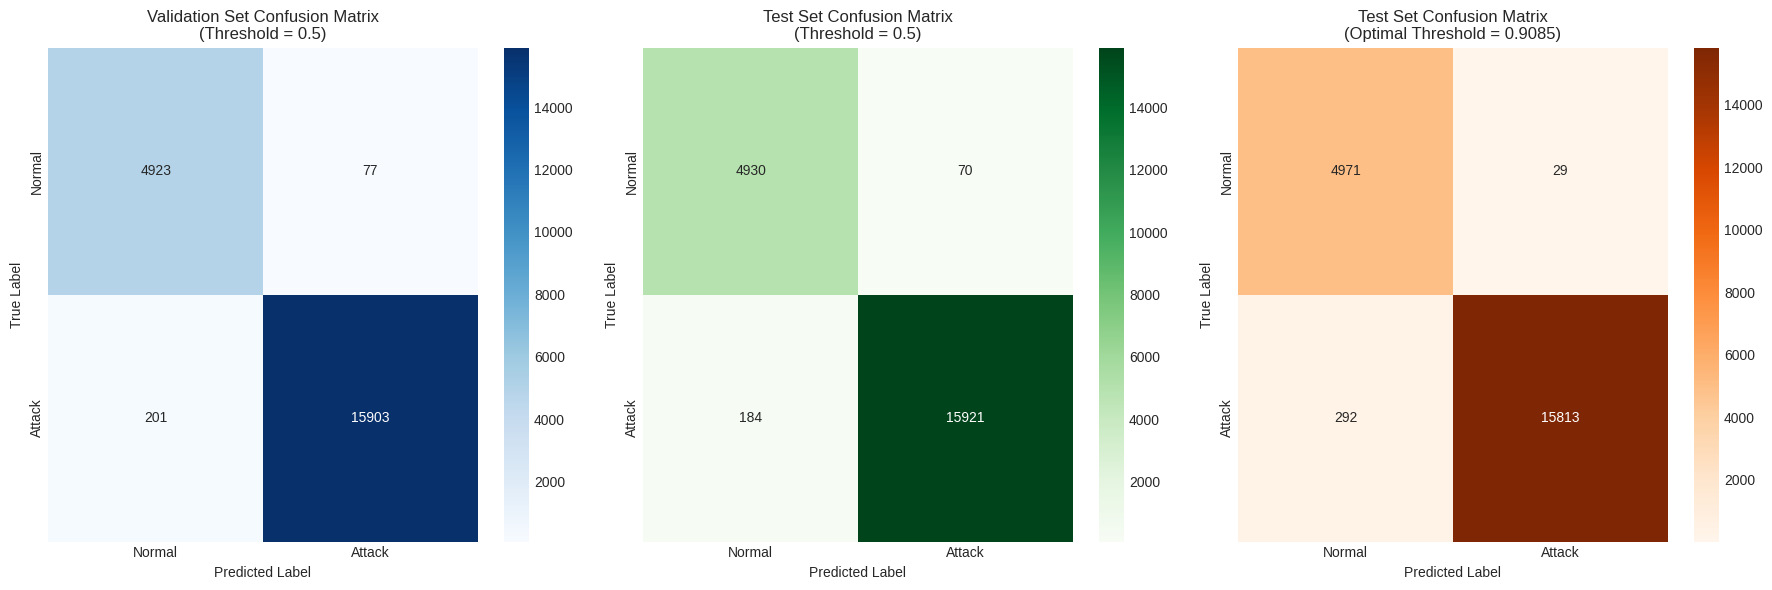

In [28]:
fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=True,
           xticklabels=['Normal', 'Attack'],
           yticklabels=['Normal', 'Attack'])
plt.title('Validation Set Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 3, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', cbar=True,
           xticklabels=['Normal', 'Attack'],
           yticklabels=['Normal', 'Attack'])
plt.title('Test Set Confusion Matrix\n(Threshold = 0.5)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 3, 3)
sns.heatmap(test_cm_optimal, annot=True, fmt='d', cmap='Oranges', cbar=True,
           xticklabels=['Normal', 'Attack'],
           yticklabels=['Normal', 'Attack'])
plt.title(f'Test Set Confusion Matrix\n(Optimal Threshold = {optimal_threshold:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

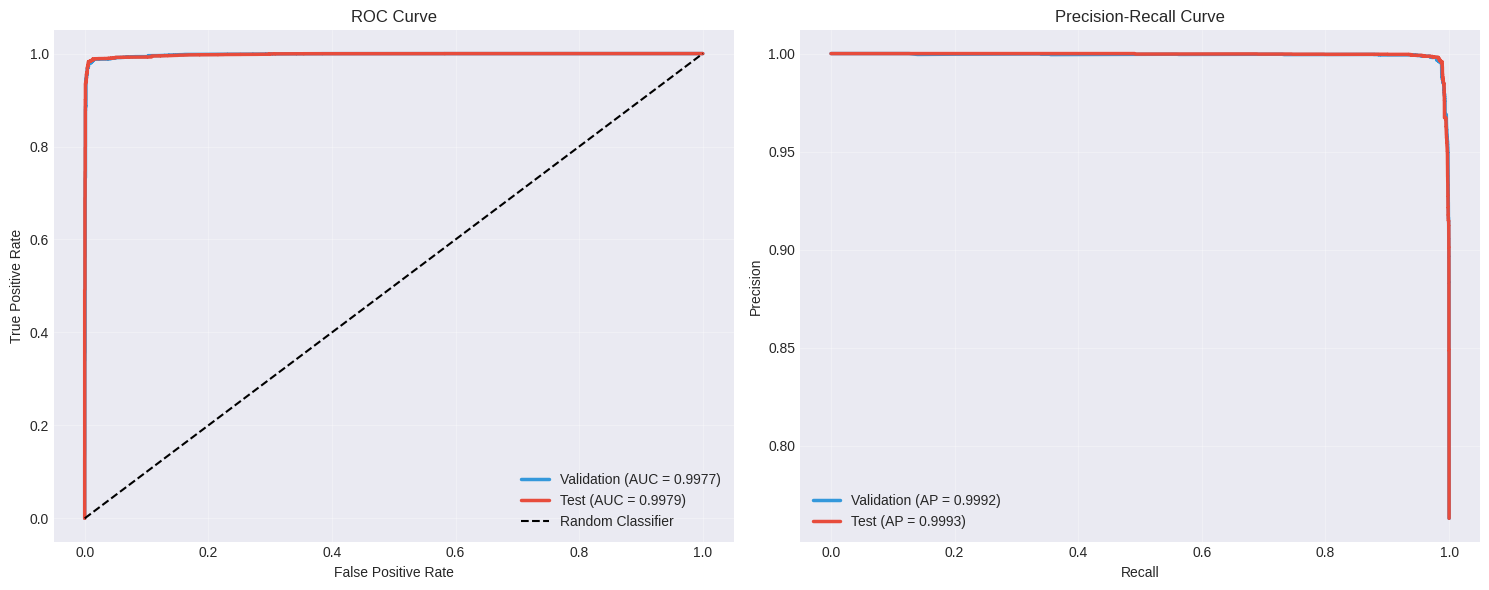

In [29]:
val_fpr, val_tpr, _ = roc_curve(y_val, val_pred_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred_prob)

val_precision_curve, val_recall_curve, _ = precision_recall_curve(y_val, val_pred_prob)
test_precision_curve, test_recall_curve, _ = precision_recall_curve(y_test, test_pred_prob)

fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_metrics["roc_auc"]:.4f})',
        linewidth=2.5, color='#3498db')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_metrics["roc_auc"]:.4f})',
        linewidth=2.5, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_recall_curve, val_precision_curve,
        label=f'Validation (AP = {val_metrics["avg_precision"]:.4f})',
        linewidth=2.5, color='#3498db')
plt.plot(test_recall_curve, test_precision_curve,
        label=f'Test (AP = {test_metrics["avg_precision"]:.4f})',
        linewidth=2.5, color='#e74c3c')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
print("\nValidation Set Classification Report:")
print(classification_report(y_val, val_pred,
                          target_names=['Normal', 'Attack'],
                          digits=4))

print("\nTest Set Classification Report:")
print(classification_report(y_test, test_pred,
                          target_names=['Normal', 'Attack'],
                          digits=4))

print("\nTest Set Classification Report (Optimal Threshold):")
print(classification_report(y_test, test_pred_optimal,
                          target_names=['Normal', 'Attack'],
                          digits=4))


Validation Set Classification Report:
              precision    recall  f1-score   support

      Normal     0.9608    0.9846    0.9725      5000
      Attack     0.9952    0.9875    0.9913     16104

    accuracy                         0.9868     21104
   macro avg     0.9780    0.9861    0.9819     21104
weighted avg     0.9870    0.9868    0.9869     21104


Test Set Classification Report:
              precision    recall  f1-score   support

      Normal     0.9640    0.9860    0.9749      5000
      Attack     0.9956    0.9886    0.9921     16105

    accuracy                         0.9880     21105
   macro avg     0.9798    0.9873    0.9835     21105
weighted avg     0.9881    0.9880    0.9880     21105


Test Set Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

      Normal     0.9445    0.9942    0.9687      5000
      Attack     0.9982    0.9819    0.9900     16105

    accuracy                         0.9848     21105
   

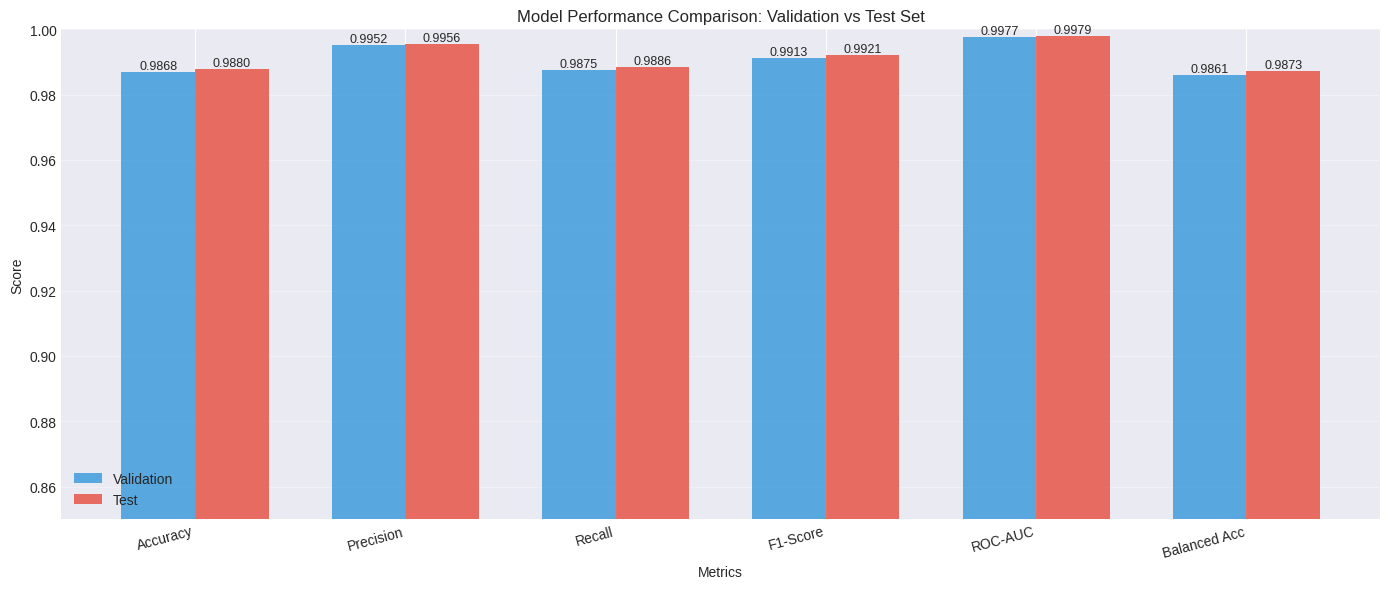

In [31]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Balanced Acc']
val_scores = [val_metrics['accuracy'], val_metrics['precision'],
              val_metrics['recall'], val_metrics['f1_score'],
              val_metrics['roc_auc'], val_metrics['balanced_accuracy']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1_score'],
               test_metrics['roc_auc'], test_metrics['balanced_accuracy']]

x_pos = np.arange(len(metrics_names))
width = 0.35

fig = plt.figure(figsize=(14, 6))
bars1 = plt.bar(x_pos - width/2, val_scores, width, label='Validation',
               color='#3498db', alpha=0.8)
bars2 = plt.bar(x_pos + width/2, test_scores, width, label='Test',
               color='#e74c3c', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison: Validation vs Test Set')
plt.xticks(x_pos, metrics_names, rotation=15, ha='right')
plt.ylim([0.85, 1.0])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
model.save('ddos_adaptive_transformer_final.keras')
print("\nModel saved as 'ddos_adaptive_transformer_final.keras'")

evaluation_results = {
    'validation_metrics': val_metrics,
    'test_metrics': test_metrics,
    'validation_cm': val_cm,
    'test_cm': test_cm,
    'validation_cm_optimal': val_cm_optimal,
    'test_cm_optimal': test_cm_optimal,
    'history': history.history,
    'optimal_threshold': optimal_threshold,
    'focal_loss_params': {'gamma': 2.0, 'alpha': 0.75}
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')
print("Evaluation results saved as 'evaluation_results.pkl'")

model_config = {
    'sequence_length': SEQUENCE_LENGTH,
    'feature_dim': FEATURE_DIM,
    'embed_dim': EMBED_DIM,
    'num_heads': NUM_HEADS,
    'ff_dim': FF_DIM,
    'num_transformer_blocks': NUM_TRANSFORMER_BLOCKS,
    'dropout_rate': DROPOUT_RATE,
    'batch_size': BATCH_SIZE,
    'optimal_threshold': optimal_threshold,
    'numeric_features': numeric_features,
    'focal_loss_gamma': 2.0,
    'focal_loss_alpha': 0.75
}
joblib.dump(model_config, 'model_config.pkl')
print("Model configuration saved as 'model_config.pkl'")


Model saved as 'ddos_adaptive_transformer_final.keras'
Evaluation results saved as 'evaluation_results.pkl'
Model configuration saved as 'model_config.pkl'


In [33]:
def predict_ddos_attack(data, model_path='ddos_adaptive_transformer_final.keras',
                       scaler_path='robust_scaler.pkl',
                       config_path='model_config.pkl'):

    get_custom_objects()['focal_loss_fixed'] = focal_loss(gamma=2.0, alpha=0.76)

    custom_objects = {
        'AdaptiveTransformerBlock': AdaptiveTransformerBlock,
        'AdaptiveAttentionLayer': AdaptiveAttentionLayer,
        'PositionalEncoding': PositionalEncoding,
        'F1Score': F1Score,
        'BalancedAccuracy': BalancedAccuracy,
        'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.76)
    }

    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    scaler = joblib.load(scaler_path)
    config = joblib.load(config_path)

    if isinstance(data, pd.DataFrame):
        X = data[config['numeric_features']].values.astype(np.float32)
    else:
        X = data.astype(np.float32)

    X_scaled = scaler.transform(X)
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e6, neginf=-1e6)

    probabilities = model.predict(X_scaled, verbose=0).flatten()
    predictions = (probabilities >= config['optimal_threshold']).astype(int)

    results = []
    for i in range(len(predictions)):
        results.append({
            'prediction': 'DDoS Attack' if predictions[i] == 1 else 'Normal Traffic',
            'probability': float(probabilities[i]),
            'confidence': float(probabilities[i]) if predictions[i] == 1 else float(1 - probabilities[i]),
            'threat_level': 'High' if probabilities[i] > 0.9 else 'Medium' if probabilities[i] > 0.7 else 'Low'
        })

    return results

In [35]:
sample_indices = np.random.choice(len(X_test_scaled), size=100, replace=False)
sample_data = X_test_scaled[sample_indices]
sample_labels = y_test[sample_indices]

predictions = predict_ddos_attack(sample_data)

print("\nSample Predictions:")
for i, (pred, true_label) in enumerate(zip(predictions, sample_labels)):
    true_class = 'DDoS Attack' if true_label == 1 else 'Normal Traffic'
    match = 'CORRECT' if (pred['prediction'] == true_class) else 'WRONG'

    print(f"\nSample {i+1}:")
    print(f"  True Label:    {true_class}")
    print(f"  Prediction:    {pred['prediction']} [{match}]")
    print(f"  Probability:   {pred['probability']:.4f}")
    print(f"  Confidence:    {pred['confidence']:.4f}")
    print(f"  Threat Level:  {pred['threat_level']}")


Sample Predictions:

Sample 1:
  True Label:    DDoS Attack
  Prediction:    Normal Traffic [WRONG]
  Probability:   0.0009
  Confidence:    0.9991
  Threat Level:  Low

Sample 2:
  True Label:    DDoS Attack
  Prediction:    DDoS Attack [CORRECT]
  Probability:   0.9986
  Confidence:    0.9986
  Threat Level:  High

Sample 3:
  True Label:    Normal Traffic
  Prediction:    Normal Traffic [CORRECT]
  Probability:   0.1781
  Confidence:    0.8219
  Threat Level:  Low

Sample 4:
  True Label:    Normal Traffic
  Prediction:    Normal Traffic [CORRECT]
  Probability:   0.0005
  Confidence:    0.9995
  Threat Level:  Low

Sample 5:
  True Label:    DDoS Attack
  Prediction:    DDoS Attack [CORRECT]
  Probability:   0.9999
  Confidence:    0.9999
  Threat Level:  High

Sample 6:
  True Label:    DDoS Attack
  Prediction:    DDoS Attack [CORRECT]
  Probability:   0.9999
  Confidence:    0.9999
  Threat Level:  High

Sample 7:
  True Label:    DDoS Attack
  Prediction:    DDoS Attack [CORRE